In [54]:
import csv
import time
from decimal import Decimal
from utils.IBRS import TRC, RSU, OBU
from utils.drawtools import pltbar, pltpoly
from random import choice

In [49]:
N = 1 # 实验次数，最后结果取平均

In [50]:
with open('./data/VID.csv') as f: # 导入 VID 池
    csv_reader = csv.reader(f)
    head = next(csv_reader)

    VID_POOL = [x for x in csv_reader]

In [51]:
def basic_test(types, time_cost, test_domain, test_func):
    for i, t in enumerate(types):
        for j in test_domain:
            result = test_func(N, j, t)
            time_cost[i].append(float(result))    

---

## [Round1 - OBU Generation] SS512 vs MNT159


In [52]:
def test_obugen(N, L, t_trc):
    recorder = []
    trc = TRC(t_trc, L, 'exp #1')
    start = time.process_time()
    for i in range(N):
        obu = OBU(trc, VID_POOL[i])
    end = time.process_time()
    cost = Decimal((Decimal(end) - Decimal(start)) * 1000 / N).quantize(Decimal("0.00"))
    return cost

横坐标： 二叉树的深度，`range(10, 19)`

纵坐标： 时间，单位：毫秒 （精确到小数点后两位）

比较对象： SS512, MNT159

---

In [53]:
types = ['MNT159', 'SS512']
time_cost = [[], []]
basic_test(types, time_cost, range(10, 19), test_obugen)

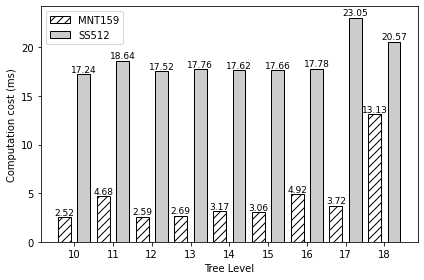

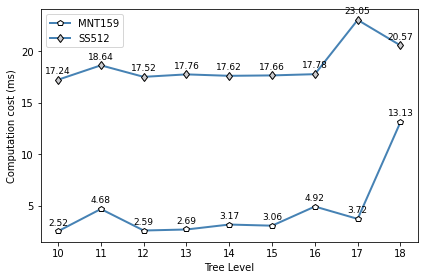

In [55]:
pltbar(len(time_cost[0]), 12, time_cost, types, range(10, 19), 'Computation cost (ms)', 2, 'Tree Level')
pltpoly(len(time_cost[0]), time_cost, types, range(10, 19), 'Computation cost (ms)', 2, 'Tree Level')

---

## [Round2 - V2I, I2V] SS512 vs MNT159

#### [Round2 - V2I]

横坐标： 二叉树的深度，range(10, 19)

纵坐标： 时间，单位：毫秒 （精确到小数点后两位）

比较对象： SS512, MNT159

In [13]:
def test_v2i(N, L, t_trc):
    recorder = []
    trc = TRC(t_trc, L, 'exp #2-1')
    obu = OBU(trc, choice(VID_POOL))
    rsu = RSU(trc, 'rsu #1')
    start = time.process_time()
    for i in range(N):
        obu.v2i(rsu.pk)        
    end = time.process_time()
    cost = Decimal((Decimal(end) - Decimal(start)) * 1000 / N).quantize(Decimal("0.00"))
    return cost

In [56]:
types = ['MNT159', 'SS512']
time_cost = [[], []]
basic_test(types, time_cost, range(10, 14), test_v2i)

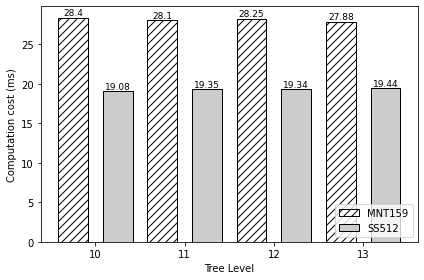

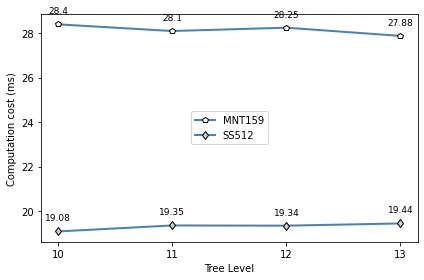

In [57]:
pltbar(len(time_cost[0]), 12, time_cost, types, range(10, 14), 'Computation cost (ms)', 4, 'Tree Level')
pltpoly(len(time_cost[0]), time_cost, types, range(10, 14), 'Computation cost (ms)', 10, 'Tree Level')

#### [Round2 - I2V]

横坐标： ring list 长度

纵坐标： 时间，单位： 毫秒 （精确到小数点后两位）

比较对象： SS512, MNT159

*默认二叉树的深度为 10*

In [40]:
def test_i2v(N, Ln, t_trc):
    recorder = []
    trc = TRC(t_trc, 10, 'exp #2-2')
    rsu = RSU(trc, 'rsu #1')
    ct = []
    for i in range(Ln):
        obu = OBU(trc, VID_POOL[i])
        ct.append(obu.v2i(rsu.pk))
    start = time.process_time()
    rsu.i2v(ct, trc.kunodes())
    end = time.process_time()
    cost = Decimal((Decimal(end) - Decimal(start)) * 1000 / N).quantize(Decimal("0.00"))
    return cost

In [58]:
types = ['MNT159', 'SS512']
time_cost = [[], []]
basic_test(types, time_cost, range(2, 9), test_v2i)

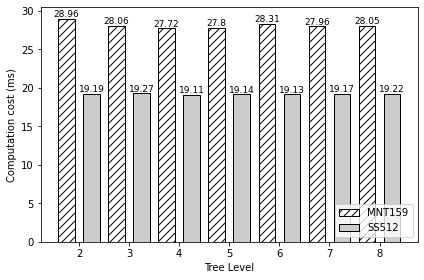

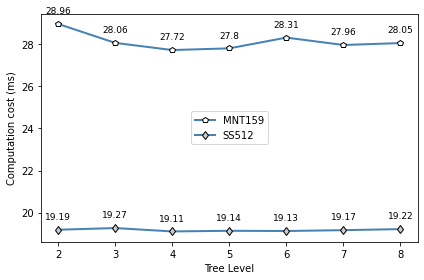

In [59]:
pltbar(len(time_cost[0]), 12, time_cost, types, range(2, 9), 'Computation cost (ms)', 4, 'Tree Level')
pltpoly(len(time_cost[0]), time_cost, types, range(2, 9), 'Computation cost (ms)', 10, 'Tree Level')

In [ ]:
---

## [Round3 - ]